### [Augmentations for Object Detection - Rotation and Shear](https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/)

In [1]:
import os
import cv2
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def draw_box(img, coords):
    """
    Function to draw bounding boxes on image.
    """
    img = img.copy()
    coords = coords.reshape(-1, 5)
    for coord in coords:
        ul_pt = (int(coord[0]), int(coord[1]))  # Upper left point
        br_pt = (int(coord[2]), int(coord[3]))  # Bottom right point
        if int(coord[4]) == 0:
            color = [255, 255, 255]
        else:
            color = [255, 255, 0]
        
        img = cv2.rectangle(img.copy(), ul_pt, br_pt, color, 
                            int(max(img.shape[:2])/200))
    return img

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def clip_bbox(bbox, clip_box, drop=0.2):
    """
    Clip bounding boxes to the borders of an image
    
    clip_box: Coordinates of image in x1, y1, x2, y2 format
    drop: If fraction of bounding box left after clipping is less 
           than drop the bounding is dropped
    """
    bb_area = bbox_area(bbox)
    
    # Updated bounding box coordinates
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1, 1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1, 1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1, 1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1, 1)
    
    # Update bounding box coordinates
    c_bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:, 4:]))
    
    # Area of clipped bounding box
    cbb_area = bbox_area(c_bbox)
    
    # Fraction of bounding box that was clipped
    delta_area = (bb_area - cbb_area)/bb_area
    
    # Mask: Drop boxes that have less than `drop` fraction 
    mask = (delta_area < (1 - drop)).astype(int)
    
    # Drop bboxes that 
    return c_bbox[mask == 1, :]

class HorizontalFlip:
    """
    Horizontally flip the image with probability p
    """
    def __init__(self, p=1): # p = 1 is deterministic
        self.p = p
        
    def __call__(self, img, bboxes):
        img_ctr = np.array(img.shape[:2])[::-1]/2
        img_ctr = np.hstack((img_ctr, img_ctr))
        if random.random() < self.p:
            # Flip image
            img = img[:,::-1,:]
            bboxes[:,[0, 2]] += 2 * (img_ctr[[0, 2]] - bboxes[:, [0, 2]]).astype(int)
            box_w = abs(bboxes[:, 0] - bboxes[:, 2])
            # Convert UR x1 to UL x1 and BL x2 to BR x2
            bboxes[:, 0] -= box_w
            bboxes[:, 2] += box_w
            
        return img, bboxes

# Rotate

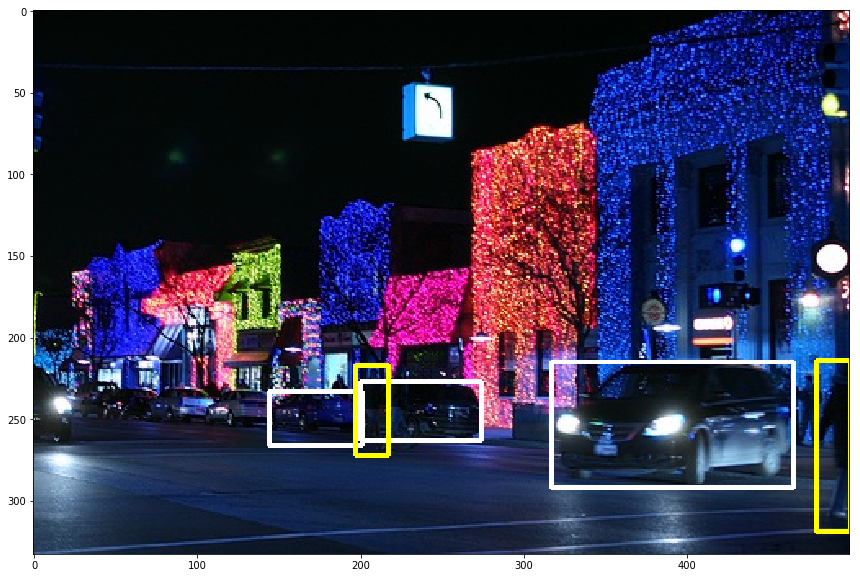

In [3]:
# Sample image from Pascal VOC with bounding box
img = cv2.imread('002244.jpg')

bboxes = np.array([[317, 215, 465, 292, 0],
                   [144, 233, 201, 266, 0],
                   [200, 227, 274, 263, 0],
                   [197, 217, 217, 272, 1],
                   [479, 214, 500, 319, 1]])

# Draw bounding boxes
img_bb = draw_box(img, bboxes)
plt.figure(figsize=(20,10))
plt.imshow(img_bb)

**Affine Transformation** - A transformation of an image such that parallel lines in an image remain parallel after the transformation. 

- Scaling
- Translation
- Rotation

Image transformation can be expressed in the form of a matrix multiplication using an *affine transformation*. The usual way to represent an *affine transformation* is using a $2 \times 3$ matrix.

$$M = \begin{bmatrix}
    a_{00}       & a_{01} & b_{00}\\
    a_{10}       & a_{11} & b_{10} \\
\end{bmatrix}$$

A 2D point $P = \begin{bmatrix} x \\ y \\ \end{bmatrix}$ can be transformed by multiplying transformation matrix $M$ with $[ x\:y\:1]^T$

$$T_p = M \cdot [ x\:y\:1]^T$$

$$T_p = \begin{bmatrix} a_{00}x + a_{01}y + b_{00}\\ a_{10}x + a_{11}y + b_{10} \\ \end{bmatrix}$$

Where: 

- $T_p$ is transformed point.


**Transformation Matrix** - It can be obtained using the rotation angle $\theta$ and the image center coordinates $(C_x, C_y)$, the matrix is expressed as:

$$\begin{bmatrix}
    \alpha & \beta & (1-\alpha)C_x - \beta C_y\\
    -\beta  & \alpha & \beta C_x + (1-\alpha) C_y \\
\end{bmatrix}$$

Where:

- $\alpha = \text{scale} \cdot \cos(\theta)$
- $\beta = \text{scale} \cdot \sin(\theta)$
- $\text{scale} = 1$ used

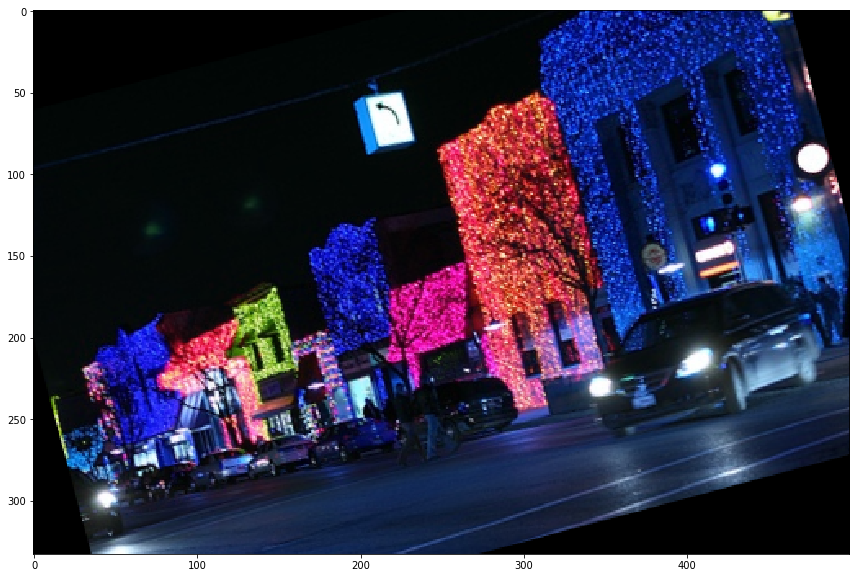

In [4]:
# Affine Transformation Example

scale = 1.0
angle = 15.0

h, w = img.shape[:2]

# Center coordinates
Cx, Cy  = (w // 2, h // 2)

# Rotation (transformation) matrix
M = cv2.getRotationMatrix2D((Cx, Cy), angle, scale)

# Transform image using transformation matrix
r_img = cv2.warpAffine(img, M, (w, h))

plt.figure(figsize=(20,10))
plt.imshow(r_img)

**Adjust coordinates to the new reference point** - *Because the image corners gets cropped after rotation transformation*

Image size as well as reference point changes after rotation so the transformation matrix needs to be modified. The new dimensions are calculated as follows:

![](https://cristianpb.github.io/assets/img/image-rotation-opencv/dessin.svg)

- $w_{new} = h \cdot \sin(\theta) + w \cdot \cos(\theta)$
- $h_{new} = h \cdot \cos(\theta) + w \cdot \sin(\theta)$

Since the image size changes, the coordinates of the rotation point (image center) also changes. The new width and height of the image is $w_{new}$ and $h_{new}$ so the center must lie at $(w_{new}/2, h_{new}/2)$. To make sure this happens translate the image by $(w_{new}/2 - C_x, h_{new}/2 - C_y)$. This is taken into account in the transformation matrix as follows:

$$\begin{bmatrix}
    \alpha & \beta & (1-\alpha)C_x - \beta C_y + (w_{new}/2 - C_x)\\
    -\beta  & \alpha & \beta C_x + (1-\alpha) C_y + (h_{new}/2 - C_y)\\
\end{bmatrix}$$

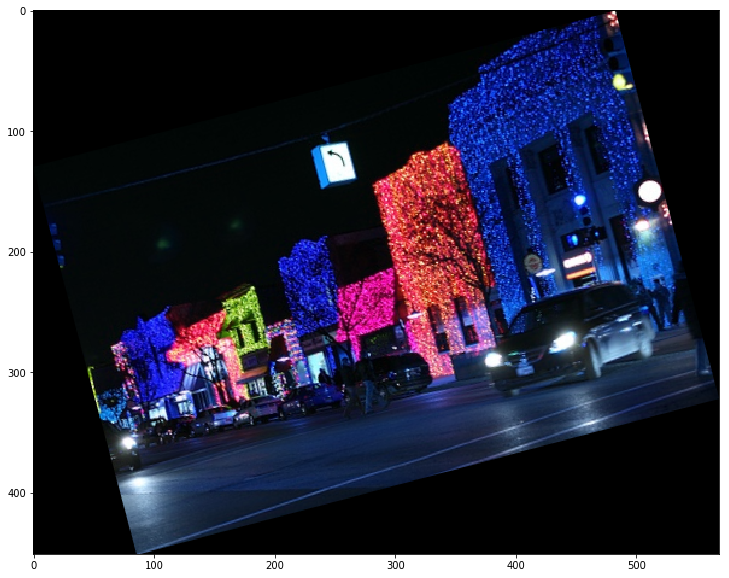

In [5]:
# Adjusting coordinates to new reference point

# Get values of cos(theta) and sin(theta) from M
cos_theta = np.abs(M[0, 0])
sin_theta = np.abs(M[0, 1])

# Calculate new width and new height
Wn = int(h * sin_theta + w * cos_theta)
Hn = int(h * cos_theta + w * sin_theta)

# Adjust rotation (transformation) matrix
M[0, 2] += (Wn/2 - Cx)
M[1, 2] += (Hn/2 - Cy)

# Transform image using transformation matrix
ru_img = cv2.warpAffine(img, M, (Wn, Hn))

plt.figure(figsize=(20,10))
plt.imshow(ru_img)

In [6]:
# Rotate Image Function
def rotate_image(image, angle):
    """
    image: np.array
    angle: float
    """
    h, w = img.shape[:2]

    # Get center coordinates of the image
    Cx, Cy  = (w // 2, h // 2)
    
    # Get rotation (transformation) matrix
    M = cv2.getRotationMatrix2D((Cx, Cy), angle, scale=1.0)
    
    # Get values of cos(theta) and sin(theta) from M
    cos_theta = np.abs(M[0, 0])
    sin_theta = np.abs(M[0, 1])
    
    # Adjust rotation (transformation) matrix
    M[0, 2] += (Wn/2 - Cx)
    M[1, 2] += (Hn/2 - Cy)

    # Transform image using transformation matrix
    r_img = cv2.warpAffine(img, M, (Wn, Hn))
    
    return r_img

### Rotating Bounding Box

- Rotate the bounding box
- Then find the **tightest rectangle parallel to the sides of the image containing the rotated bounding box**

In [7]:
# Get 4 corner coordinates of bounding boxes

width = (bboxes[:, 2] - bboxes[:, 0]).reshape(-1, 1)
height = (bboxes[:, 3] - bboxes[:, 1]).reshape(-1, 1)

x1 = bboxes[:, 0].reshape(-1, 1)
y1 = bboxes[:, 1].reshape(-1, 1)

x2 = x1 + width
y2 = y1

x3 = x1
y3 = y1 + height

x4 = bboxes[:, 2].reshape(-1, 1)
y4 = bboxes[:, 3].reshape(-1, 1)

corners = np.hstack((x1, y2, x2, y2, x3, y3, x4, y4))
corners

array([[317, 215, 465, 215, 317, 292, 465, 292],
       [144, 233, 201, 233, 144, 266, 201, 266],
       [200, 227, 274, 227, 200, 263, 274, 263],
       [197, 217, 217, 217, 197, 272, 217, 272],
       [479, 214, 500, 214, 479, 319, 500, 319]])

In [8]:
# Rotate bounding boxes

# Reshape corners --> [x, y]
corners = corners.reshape(-1, 2)

# Add column of 1's in corners --> [x, y, 1]
corners = np.hstack((corners, np.ones((corners.shape[0], 1), dtype=type(corners[0][0]))))

# Get rotation matrix
M = cv2.getRotationMatrix2D((Cx, Cy), angle, 1.0)

# Get values of cos(theta) and sin(theta) from M
cos_theta = np.abs(M[0, 0])
sin_theta = np.abs(M[0, 1])

# Calculate new width and new height
Wn = int(h * sin_theta + w * cos_theta)
Hn = int(h * cos_theta + w * sin_theta)

# Adjust rotation (transformation) matrix
M[0, 2] += (Wn/2 - Cx)
M[1, 2] += (Hn/2 - Cy)

# Rotate the bounding boxes
r_bboxes = np.dot(M, corners.T).T

# Reshape rotated bounding boxes such that there are 8 columns
r_bboxes = r_bboxes.reshape(-1, 8)

In [9]:
# Create enclosing bounding box

# Get X and Y from rotated bounding boxes
Xs = r_bboxes[:, [0, 2, 4, 6]]
Ys = r_bboxes[:, [1, 3, 5, 7]]

# Set UL x's as min of X's, UL y's min of Y's
x_min = np.min(Xs, axis=1).reshape(-1, 1)
y_min = np.min(Ys, axis=1).reshape(-1, 1)

# Set BR x's as max of X's, BR y's max of Y's
x_max = np.max(Xs, axis=1).reshape(-1, 1)
y_max = np.max(Ys, axis=1).reshape(-1, 1)

# Get enclosing bounding boxes
er_bboxes = np.hstack((x_min, y_min, x_max, y_max, bboxes[:,4].reshape(-1, 1)))
er_bboxes

array([[361.89916357, 217.18427079, 524.78525234, 329.86577809,
          0.        ],
       [199.45273844, 302.89916357, 263.05153902, 349.52740141,
          0.        ],
       [251.99167044, 278.20981832, 332.78766721, 332.13575741,
          0.        ],
       [246.50570251, 283.30324563, 280.05926651, 341.60554698,
          1.        ],
       [518.12032839, 207.15967839, 565.58077047, 314.01709009,
          1.        ]])

In [10]:
scale_x = r_img.shape[1]/img.shape[1]
scale_y = r_img.shape[0]/img.shape[0]

sr_img = cv2.resize(r_img, (img.shape[1], img.shape[0]))

er_bboxes[:,:4] = er_bboxes[:,:4] / [scale_x, scale_y, scale_x, scale_y]

c_bboxes = clip_bbox(er_bboxes, [0, 0, img.shape[1], img.shape[0]], 0.25)

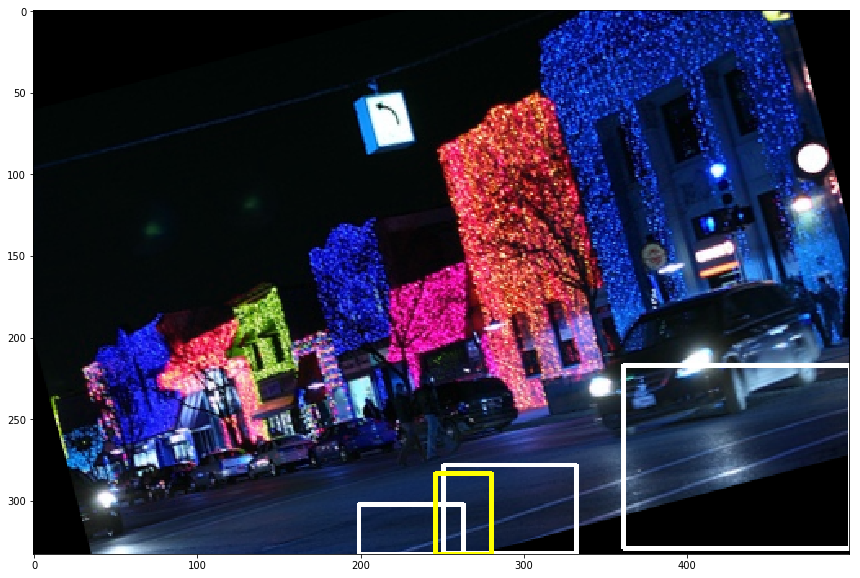

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(draw_box(sr_img, c_bboxes))

In [12]:
# Get corners of bounding box
def get_bboxes_corners(bboxes):
    """
    Numpy array of shape N x 8 containing N bounding boxes each 
    described by their corner co-ordinates x1 y1 x2 y2 x3 y3 x4 y4 
    
    bboxes: np.ndarray
    """
    width = (bboxes[:, 2] - bboxes[:, 0]).reshape(-1, 1)
    height = (bboxes[:, 3] - bboxes[:, 1]).reshape(-1, 1)
    
    x1 = bboxes[:, 0].reshape(-1, 1)
    y1 = bboxes[:, 1].reshape(-1, 1)
    
    x2 = x1 + width
    y2 = y1
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:, 2].reshape(-1, 1)
    y4 = bboxes[:, 3].reshape(-1, 1)
    
    return np.hstack((x1, y2, x2, y2, x3, y3, x4, y4))

# Rotate bounding box
def rotate_bboxes(corners, angle, Cx, Cy, h, w):
    """
    Rotate bounding boxes.
    
    corners: np.ndarray
    angle: float
    Cx: int, x coordinate of the image center, about which bbox will rotate
    Cy: int, y coordinate of the image center, about which bbox will rotate
    h: int, height of the image
    w: int, width of the image
    """
    # Reshape corners --> [x, y]
    corners = corners.reshape(-1, 2)

    # Add column of 1's in corners --> [x, y, 1]
    corners = np.hstack((corners, np.ones((corners.shape[0], 1), dtype=type(corners[0][0]))))

    # Get rotation matrix
    M = cv2.getRotationMatrix2D((Cx, Cy), angle, 1.0)

    # Get values of cos(theta) and sin(theta) from M
    cos_theta = np.abs(M[0, 0])
    sin_theta = np.abs(M[0, 1])

    # Calculate new width and new height
    Wn = int(h * sin_theta + w * cos_theta)
    Hn = int(h * cos_theta + w * sin_theta)

    # Adjust rotation (transformation) matrix
    M[0, 2] += (Wn/2 - Cx)
    M[1, 2] += (Hn/2 - Cy)

    # Rotate the bounding boxes
    r_bboxes = np.dot(M, corners.T).T

    # Reshape rotated bounding boxes such that there are 8 columns
    r_bboxes_coords = r_bboxes.reshape(-1, 8)
    
    return r_bboxes_coords

# Create enclosing bounding box
def create_enclosing_bboxes(r_bboxes_coords):
    """
    r_bboxes: np.ndarray, rotated bounding boxes coordinates
    """
    # Get X and Y from rotated bounding boxes
    Xs = r_bboxes_coords[:, [0, 2, 4, 6]]
    Ys = r_bboxes_coords[:, [1, 3, 5, 7]]

    # Set UL x's as min of X's, UL y's min of Y's
    x_min = np.min(Xs, axis=1).reshape(-1, 1)
    y_min = np.min(Ys, axis=1).reshape(-1, 1)

    # Set BR x's as max of X's, BR y's max of Y's
    x_max = np.max(Xs, axis=1).reshape(-1, 1)
    y_max = np.max(Ys, axis=1).reshape(-1, 1)

    return np.hstack((x_min, y_min, x_max, y_max, r_bboxes_coords[:,8:]))

In [13]:
class Rotate:
    
    def __init__(self, angle):
        self.angle = angle
        
    def __call__(self, img, bboxes):
        
        angle = self.angle
        h, w = img.shape[:2]

        # Get center coordinates of the image
        Cx, Cy  = (w // 2, h // 2)
        
        # Get corners
        corners = get_bboxes_corners(bboxes)
        corners = np.hstack((corners, bboxes[:,4:]))
        
        # Rotate image
        img = rotate_image(img, angle)
        
        # Rotate bounding boxes
        corners[:,:8] = rotate_bboxes(corners[:,:8], angle, Cx, Cy, h, w)
        
        # Create enclosing bounding boxes
        e_bboxes = create_enclosing_bboxes(corners)
        
        scale_x = img.shape[1]/w
        scale_y = img.shape[0]/h
        
        img = cv2.resize(img, (w, h))
        
        e_bboxes[:,:4] = e_bboxes[:,:4] / [scale_x, scale_y, scale_x, scale_y]
        
        c_bboxes = clip_bbox(e_bboxes, [0, 0, w, h], 0.25)
        
        return img, c_bboxes

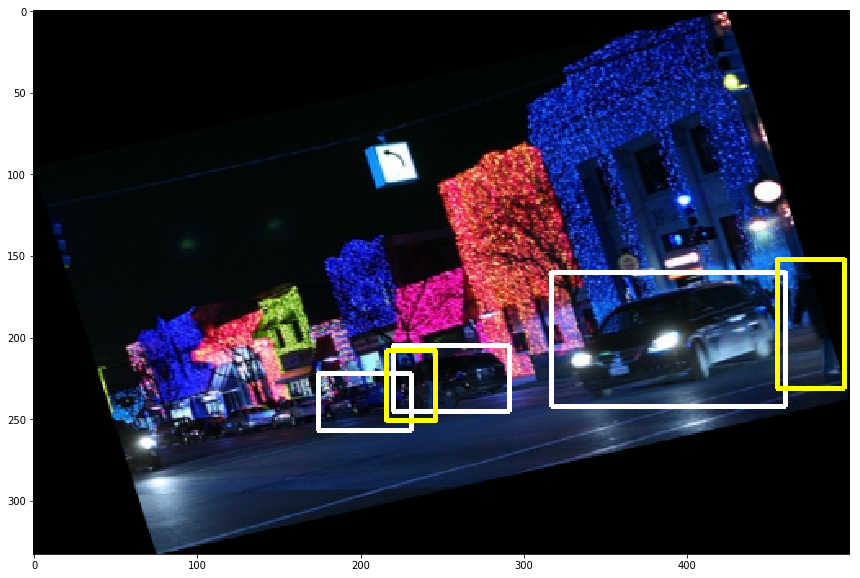

In [14]:
# Test rotate
rotate = Rotate(15)
r_img, r_bboxes = rotate(img, bboxes)
plt.figure(figsize=(20,10))
plt.imshow(draw_box(r_img, r_bboxes))

# Shear

- In shearing, the rectangular image is turned into a parallelogram image. The transformation matrix used in horizontal shearing is:



$$M = \begin{bmatrix}
    1 & 0 & \lambda \\
    0 & 1 & 0 \\
\end{bmatrix}$$

Where: $\lambda$ is **shear factor**. The pixel with coordinates $(x, y)$ is moved to coordinate $(x + \lambda y, y)$

In [15]:
# Sample image from Pascal VOC with bounding box
img = cv2.imread('002244.jpg')

bboxes = np.array([[317, 215, 465, 292, 0],
                   [144, 233, 201, 266, 0],
                   [200, 227, 274, 263, 0],
                   [197, 217, 217, 272, 1],
                   [479, 214, 500, 319, 1]])

In [16]:
# Shear factor
shear = 0.2
shear = (-shear, shear)
shear = random.uniform(*shear)
print(shear)

-0.004708509361605218


In [17]:
# Transformation Matrix
M = np.array([[1, abs(shear), 0], [0, 1, 0]])

Wn = img.shape[1] + abs(shear * img.shape[0])
print(Wn)

501.56793361741455


In [18]:
# Shear bounding boxes
s_bboxes = bboxes.copy()

s_bboxes[:, [0, 2]] += (s_bboxes[:, [1, 3]] * abs(shear)).astype(int)

In [19]:
# Shear image
s_img = cv2.warpAffine(img, M, (int(Wn), img.shape[0]))

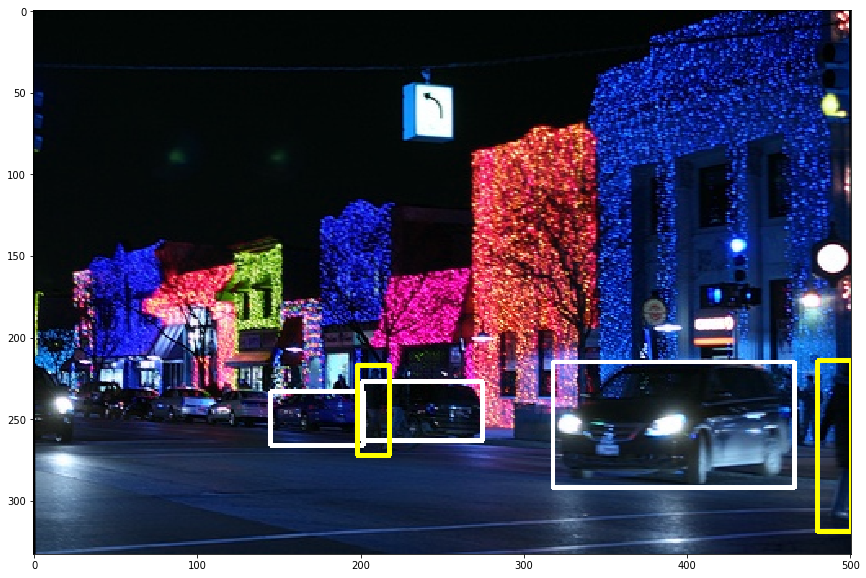

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(draw_box(s_img, s_bboxes))

In [21]:
# Shear
class Shear:
    
    def __init__(self, shear=0.2):
        self.shear = shear
        if isinstance(self.shear, tuple):
            assert len(self.shear) == 2, "Invalid range"
        else:
            self.shear = (-self.shear, self.shear)
                    
    def __call__(self, img, bboxes):
        shear_factor = random.uniform(*self.shear)
        w, h = img.shape[1], img.shape[0]
        
        # Take care of negative shear
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
        
        # Transformation Matrix
        M = np.array([[1, abs(shear_factor), 0], [0, 1, 0]])
        
        # New width
        Wn = img.shape[1] + abs(shear_factor * img.shape[0])
        
        # Shear bounding boxes
        bboxes[:, [0, 2]] += (bboxes[:, [1, 3]] * abs(shear_factor)).astype(int)
        
        # Apply shear transformation
        img = cv2.warpAffine(img, M, (int(Wn), img.shape[0]))
        
        # Take care of negative shear
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
            
        # Resize image
        img = cv2.resize(img, (w, h))
        
        # Scale factor in x direction
        scale_x = Wn/w
        
        # Resize bounding boxes
        bboxes[:, :4] = bboxes[:, :4]/[scale_x, 1, scale_x, 1]
        
        return img, bboxes

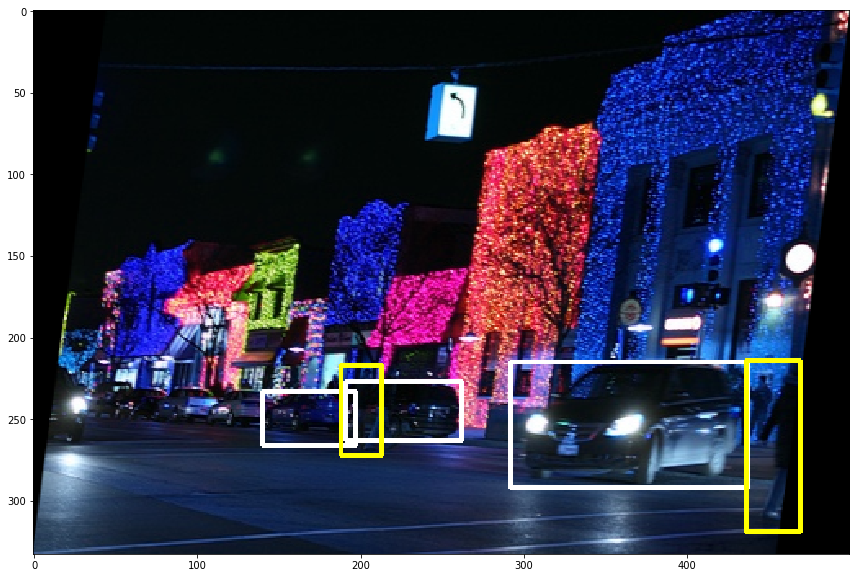

In [22]:
# Test Shear
shear = Shear(0.2)
s_img, s_bboxes = shear(img, bboxes)
plt.figure(figsize=(20,10))
plt.imshow(draw_box(s_img, s_bboxes))

#### More Information

- **[2D Transformations](https://www.tutorialspoint.com/computer_graphics/2d_transformation.htm)**
- **[Image rotation using OpenCV](https://cristianpb.github.io/blog/image-rotation-opencv)**